In [2]:
from notebook_utils import setup, load_tweet_df

setup()

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from data_tools import load_parsed_data

In [4]:

from data_tools import load_crawled_terms
crawled_terms, crawled_hashtags, crawled_phrases = load_crawled_terms("../keywords-3nov.txt", split_hashtags=True)


In [5]:
def filter_df_by_timestamp(df):
    return df[(df.timestamp > '2020-11-06 00:00:00') & (df.timestamp < '2020-11-07 00:00:00')]

# Load our tweets
cast_cols = {
    "tweet_count": "int32",
    "quote_count": "int32" 
}

for term in crawled_terms:
    cast_cols[term] = "Sparse[int8]"

tweet_df = filter_df_by_timestamp(load_parsed_data('../data/14-nov/parsed_tweets.json', exclude_cols={
    "cleaned_text", 
    "entities",
    "replyTo",
    "replyTo_user",
    "last_retweeted", 
    "place", 
    "processed",
    "media", 
    "isDeleted"
}, cast_cols=cast_cols, verbose=True, index_col="datastore_id"))
retweet_df = filter_df_by_timestamp(load_parsed_data('../data/14-nov/parsed_retweets.json'))

Loading 2696807 json lines
(4%): 100000 lines in ../data/14-nov/parsed_tweets.json processed (2.0554921627044678 sec)
(7%): 200000 lines in ../data/14-nov/parsed_tweets.json processed (2.2128069400787354 sec)
(11%): 300000 lines in ../data/14-nov/parsed_tweets.json processed (2.621595859527588 sec)
(15%): 400000 lines in ../data/14-nov/parsed_tweets.json processed (2.335399866104126 sec)
(19%): 500000 lines in ../data/14-nov/parsed_tweets.json processed (2.3703670501708984 sec)
(22%): 600000 lines in ../data/14-nov/parsed_tweets.json processed (2.6340138912200928 sec)
(26%): 700000 lines in ../data/14-nov/parsed_tweets.json processed (1.3846349716186523 sec)
(30%): 800000 lines in ../data/14-nov/parsed_tweets.json processed (2.9366867542266846 sec)
(33%): 900000 lines in ../data/14-nov/parsed_tweets.json processed (1.4737679958343506 sec)
(37%): 1000000 lines in ../data/14-nov/parsed_tweets.json processed (3.372375011444092 sec)
(41%): 1100000 lines in ../data/14-nov/parsed_tweets.json

In [6]:
# build lookup table for retweets
from collections import defaultdict 
retweets_by_user = defaultdict(lambda: set())

for retweet in retweet_df.itertuples():
    retweets_by_user[retweet.user].add(retweet.retweeted)

In [7]:
def is_tweet_tagged_with_hashtag(tweet, hashtag):
    for tweet_hashtag in tweet['entities']['hashtags']:
        if tweet_hashtag['text'].lower() == hashtag.lower():
            return True
    return False

def does_tweet_contain_any_term(tweet, terms):
    for term in terms:
        if term in tweet['full_text'].lower():
            return True
    return False

In [9]:
import gzip
import json
import os


hydrated_tweet_dir = '../data/coverage-test-us-pres/2020-11-06/hydrated/'

line_count = 0
ferrata_tweet_count = 0
ferrata_retweet_count = 0
ferrata_matching_tweets = []
ferrata_matching_retweets = []

ferrata_ballot_tweet_ids = set()

for filename in os.listdir(hydrated_tweet_dir):
    if filename.endswith(".jsonl.gz"):
        print("Processing {}".format(filename))
        with gzip.open(hydrated_tweet_dir + filename) as zipfile:
            for line in zipfile:
                tweet = json.loads(line)
                is_retweet = 'retweeted_status' in tweet
                match_array = ferrata_matching_retweets if is_retweet else ferrata_matching_tweets 
                
                line_count += 1
                if is_retweet:
                    ferrata_retweet_count += 1
                else:
                    ferrata_tweet_count += 1
                
                if (line_count % 25000 == 0):
                    print("Processed {} lines ({} tweets / {} retweets)".format(line_count, ferrata_tweet_count, ferrata_retweet_count))
                
                if ("ballot" in tweet["full_text"].lower()):
                    ferrata_ballot_tweet_ids.add(str(tweet["id"]))

                for hashtag in crawled_hashtags:
                    if (is_tweet_tagged_with_hashtag(tweet, hashtag)):
                        match_array.append(tweet)
                        break
                if (does_tweet_contain_any_term(tweet, crawled_phrases)):
                    match_array.append(tweet)
        print("Total crawled terms found: {} tweets / {} retweets".format(len(ferrata_matching_tweets), len(ferrata_matching_retweets)))
        print("{} tweets containing 'ballot'".format(len(ferrata_ballot_tweet_ids)))

Processing us-presidential-tweet-id-2020-11-06-19.jsonl.gz
Processed 25000 lines (7060 tweets / 17940 retweets)
Processed 50000 lines (13656 tweets / 36344 retweets)
Processed 75000 lines (20486 tweets / 54514 retweets)
Processed 100000 lines (27259 tweets / 72741 retweets)
Processed 125000 lines (34123 tweets / 90877 retweets)
Processed 150000 lines (40848 tweets / 109152 retweets)
Processed 175000 lines (47711 tweets / 127289 retweets)
Processed 200000 lines (54436 tweets / 145564 retweets)
Total crawled terms found: 1444 tweets / 5714 retweets
24666 tweets containing 'ballot'
Processing us-presidential-tweet-id-2020-11-06-18.jsonl.gz
Processed 225000 lines (60835 tweets / 164165 retweets)
Processed 250000 lines (67016 tweets / 182984 retweets)
Processed 275000 lines (73293 tweets / 201707 retweets)
Processed 300000 lines (79660 tweets / 220340 retweets)
Processed 325000 lines (86369 tweets / 238631 retweets)
Processed 350000 lines (92930 tweets / 257070 retweets)
Processed 375000 li

In [11]:
print(len(ferrata_matching_tweets))
print(len(ferrata_ballot_tweet_ids))

33395
360652


In [12]:
matching_tweets_by_term = defaultdict(lambda: set())
missing_tweets_by_term = defaultdict(lambda: set())

matching_retweets_by_term = defaultdict(lambda: set())
missing_retweets_by_term = defaultdict(lambda: set())
missing_tweets = []
missing_retweets = []

def add_tweet_to_term_stats(term_stats, tweet):
    for term in crawled_phrases:
        if term in tweet['full_text'].lower():
            term_stats[term].add(tweet['full_text'])
    for hashtag in crawled_hashtags:
        if (is_tweet_tagged_with_hashtag(tweet, hashtag)):
            term_stats['#' + hashtag].add(tweet['full_text'])

for tweet in ferrata_matching_tweets:
    if (str(tweet['id']) in tweet_df.index):
        add_tweet_to_term_stats(matching_tweets_by_term, tweet)
    else:
        missing_tweets.append(tweet)
        add_tweet_to_term_stats(missing_tweets_by_term, tweet)

for retweet in ferrata_matching_retweets:
    retweeted_tweet = retweet['retweeted_status']
    user_id = str(retweet['user']['id'])
    if (str(retweeted_tweet['id']) in retweets_by_user[user_id]):
        add_tweet_to_term_stats(matching_retweets_by_term, retweet)
    else:
        add_tweet_to_term_stats(missing_retweets_by_term, retweet)
        missing_retweets.append(retweet)

In [13]:
def print_missing_stats(matching, missing, matching_by_term, missing_by_term, stats_type):
    print("Missing {}/{} {} ({:,.1f}%)".format(
        len(missing),
        len(matching),
        stats_type,
        (len(missing) / len(matching)) * 100
    ))
    
    for (term, missing_set) in sorted(missing_by_term.items(), key=lambda x: -len(x[1])):
        if (len(missing_set) > 0):
            total = (len(missing_set) + len(matching_by_term[term]))
            print("Missed {:,.1f}% for term: '{}' ({}/{})".format(
                (len(missing_set) / total) * 100,
                term,
                len(missing_set),
                total
            ))      

In [15]:
print_missing_stats(ferrata_matching_tweets, missing_tweets, matching_tweets_by_term, missing_tweets_by_term, 'tweets')

Missing 22532/33395 tweets (67.5%)
Missed 67.9% for term: 'voter fraud' (13344/19652)
Missed 67.0% for term: '#stopthesteal' (2693/4022)
Missed 65.9% for term: '#voterfraud' (2515/3817)
Missed 67.1% for term: 'election fraud' (2178/3247)
Missed 68.8% for term: '#electionfraud' (664/965)
Missed 65.3% for term: 'ballot harvesting' (516/790)
Missed 65.0% for term: 'ballot fraud' (417/642)
Missed 64.2% for term: 'election interference' (248/386)
Missed 77.7% for term: 'democrats cheat' (199/256)
Missed 77.5% for term: '#electioninterference' (131/169)
Missed 65.3% for term: '#ballotharvesting' (113/173)
Missed 57.8% for term: '#cheatingdemocrats' (85/147)
Missed 66.7% for term: '#voterfraudisreal' (70/105)
Missed 66.7% for term: 'cheating democrats' (58/87)
Missed 66.2% for term: 'stolen ballots' (49/74)
Missed 57.1% for term: 'election tampering' (44/77)
Missed 70.0% for term: '#ballotfraud' (35/50)
Missed 79.2% for term: '#democratvoterfraud' (19/24)
Missed 83.3% for term: '#stopvoterfra

In [16]:
print_missing_stats(ferrata_matching_retweets, missing_retweets, matching_retweets_by_term, missing_retweets_by_term, 'retweets')

Missing 93596/129797 retweets (72.1%)
Missed 65.0% for term: 'voter fraud' (5156/7938)
Missed 65.4% for term: '#voterfraud' (848/1297)
Missed 63.2% for term: 'election fraud' (841/1331)
Missed 67.5% for term: '#stopthesteal' (829/1229)
Missed 64.2% for term: 'ballot fraud' (188/293)
Missed 68.8% for term: 'ballot harvesting' (181/263)
Missed 67.5% for term: '#electionfraud' (141/209)
Missed 59.3% for term: 'election interference' (89/150)
Missed 72.1% for term: 'democrats cheat' (44/61)
Missed 64.6% for term: '#electioninterference' (31/48)
Missed 52.4% for term: '#ballotharvesting' (22/42)
Missed 55.0% for term: '#cheatingdemocrats' (22/40)
Missed 62.5% for term: '#voterfraudisreal' (20/32)
Missed 58.3% for term: 'stolen ballots' (14/24)
Missed 63.6% for term: 'election tampering' (14/22)
Missed 72.7% for term: 'discarded ballots' (8/11)
Missed 70.0% for term: 'cheating democrats' (7/10)
Missed 46.2% for term: '#ballotfraud' (6/13)
Missed 80.0% for term: '#stopvoterfraud' (4/5)
Missed

### Random sample of missing tweets/retweets



In [64]:
import numpy as np

print("-- Missing tweets --")
for tweet in np.random.choice(missing_tweets, 5):
    print("[{}]: {}".format(tweet['id'], tweet['full_text']))
    print()

print()

print("-- Missing retweets --")
for retweet in np.random.choice(missing_retweets, 5):
    print("[{}]: {}".format(retweet['id'], retweet['full_text']))
    print()

-- Missing tweets --
[1324691936326934528]: BREAKING: Arizona Voter Fraud Scheme EXPOSED https://t.co/ULfjZy0AnM

[1324502524645298188]: @realDonaldTrump So all the election interference from the Russians in 2016 Trump quiet. Now he losing bigly he claims election interference by the democrats even in Republican run states. What a loser!!

[1324606997421912064]: @CTVNews The world sees the voter fraud.

[1324506098326409217]: @linzcom If there’s voter fraud, surely it’s most likely being committed by Trump supporters? The reason being he actively told them to go and commit voter fraud.

[1324539237731983360]: More voter fraud in action: https://t.co/NfDQ4Ziig6


-- Missing retweets --
[1324591934900494337]: RT @realannapaulina: Putting together a list of every single member of the GOP that is silent on the voter fraud taking place. 

In 2022, I…

[1324503514815500288]: RT @katestarbird: Pretty much a catch-all for every false narrative about voter fraud that his supporters and he have 

In [87]:
# Create a dataframe from Ferrata's tweets/retweets
mapped_tweets = [{
    "tweet_id": str(tweet["id"]), 
    "full_text": tweet["full_text"], 
    "timestamp": tweet["created_at"], 
    "hashtags": list(map(lambda x: x["text"].lower(), tweet["entities"]["hashtags"]))
} for tweet in ferrata_matching_tweets]
ferrata_tweet_df = pd.DataFrame(mapped_tweets)

mapped_retweets = [{
    "retweet_id": str(tweet["id"]), 
    "full_text": tweet["full_text"], 
    "timestamp": tweet["created_at"], 
    "hashtags": list(map(lambda x: x["text"].lower(), tweet["entities"]["hashtags"]))
} for tweet in ferrata_matching_retweets]
ferrata_retweet_df = pd.DataFrame(mapped_retweets)

In [63]:
def filter_by_term(df, crawled_term):
    if (crawled_term[0] == '#'):
        hashtag = crawled_term[1:]
        m = df.apply(lambda x: hashtag.lower() in x['hashtags'], axis=1)
    else:
        m = df.apply(lambda x: term.lower() in x['full_text'].lower(), axis=1)
    return df[m]

In [64]:
def group_df_by_hour(df, column='timestamp'):
    grouped_by_hour = (pd.to_datetime(df[column])
        .dt.floor('H')
        .value_counts()
        .rename_axis('date')
        .reset_index(name='count')).sort_values(by=['date'])
    return grouped_by_hour.set_index('date')

def plot_hourly_coverage(our_df, matching_df, title):
    our_df_by_hour = group_df_by_hour(our_df)
    matching_df_by_hour = group_df_by_hour(matching_df)

    fig, ax = plt.subplots(figsize=(14,8), dpi=80)

    ax.plot(
        our_df_by_hour["count"], label="Our dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.plot(
        matching_df_by_hour["count"], label="Their dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))

    ax.set_title("Coverage for '{}' (total={:,}/{:,})".format(title, len(our_df.index), len(matching_df.index)))

    return fig

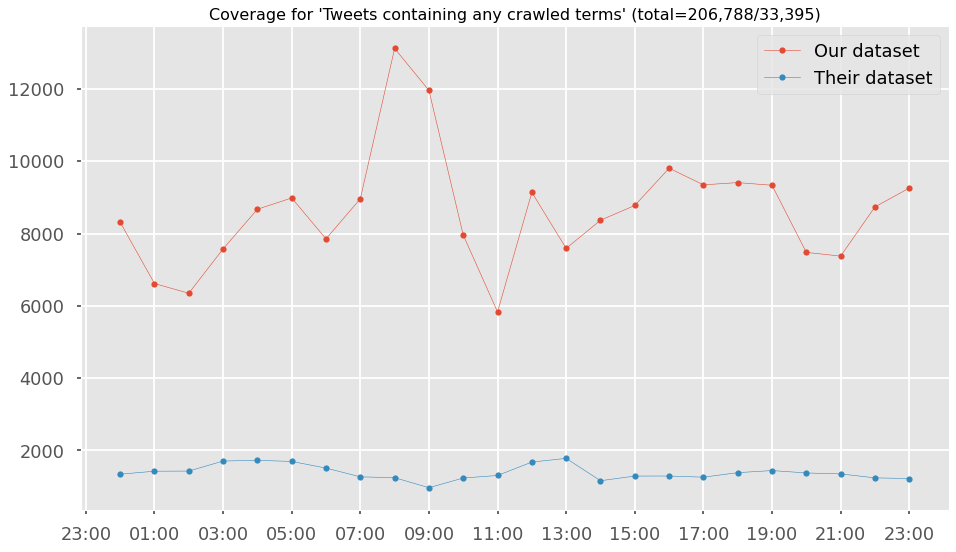

In [65]:
plot_hourly_coverage(tweet_df, ferrata_tweet_df, "Tweets containing any crawled terms")
None

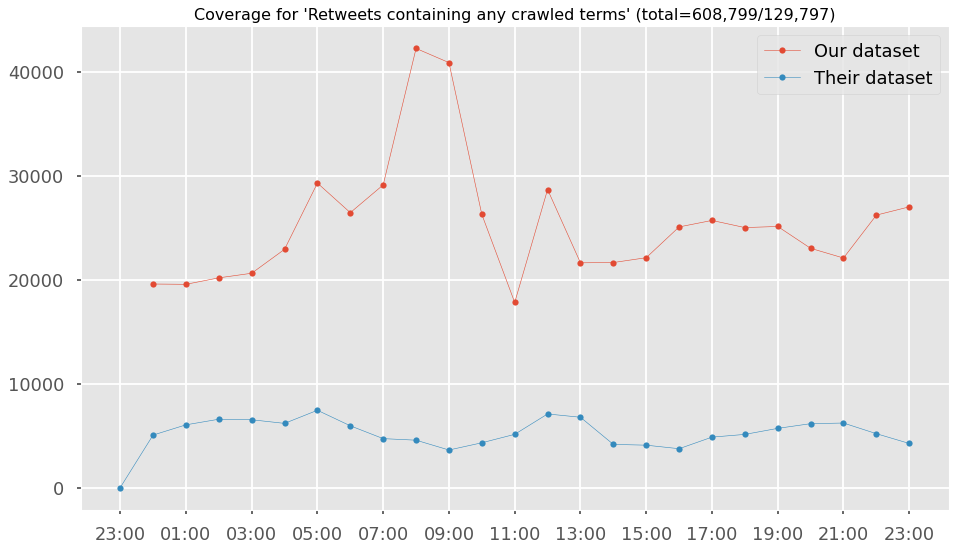

In [66]:
plot_hourly_coverage(retweet_df, ferrata_retweet_df, "Retweets containing any crawled terms")
None

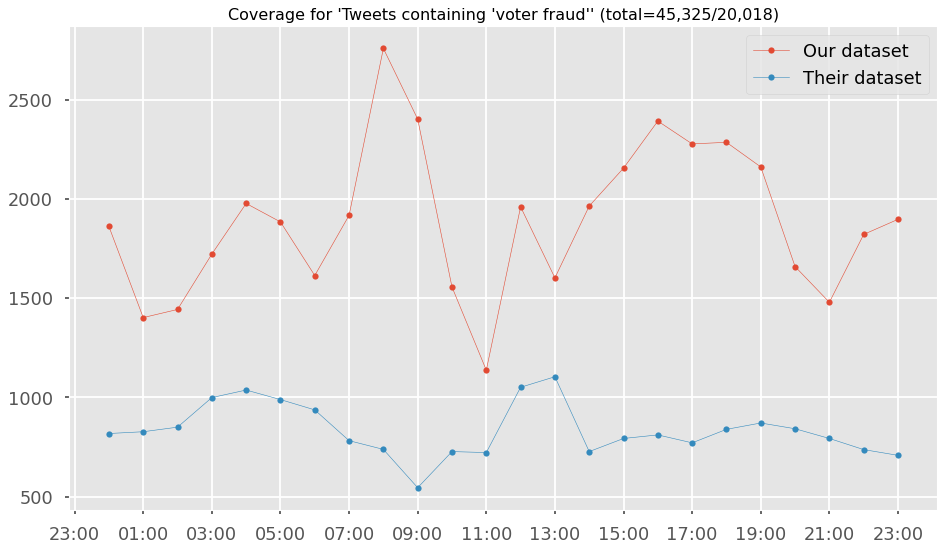

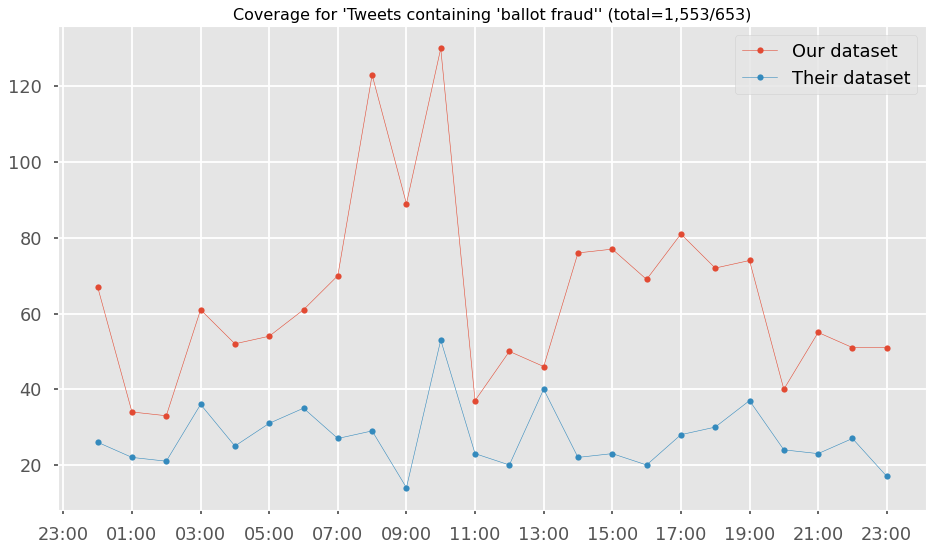

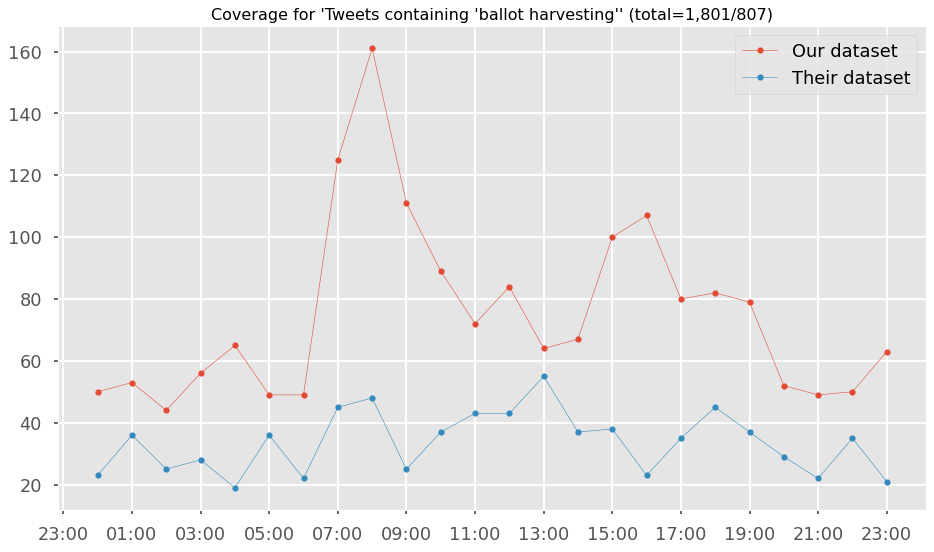

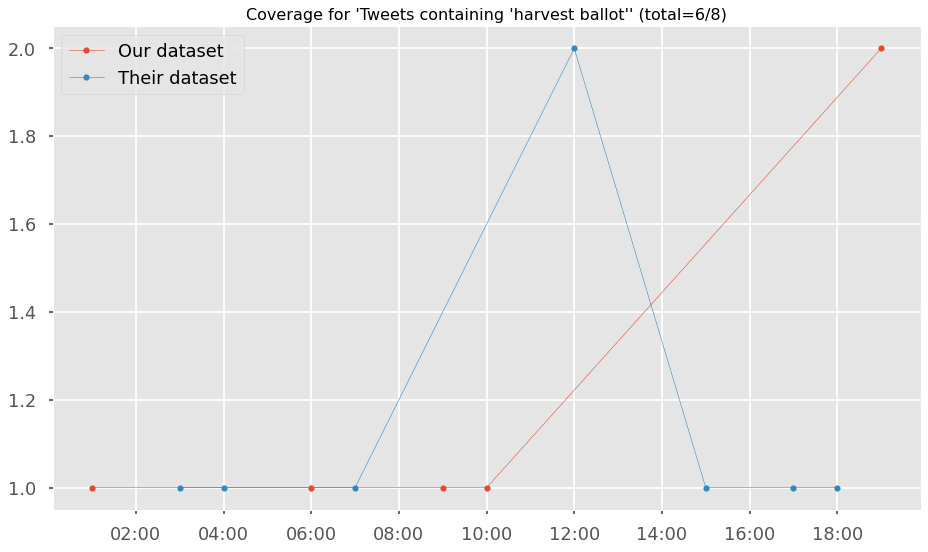

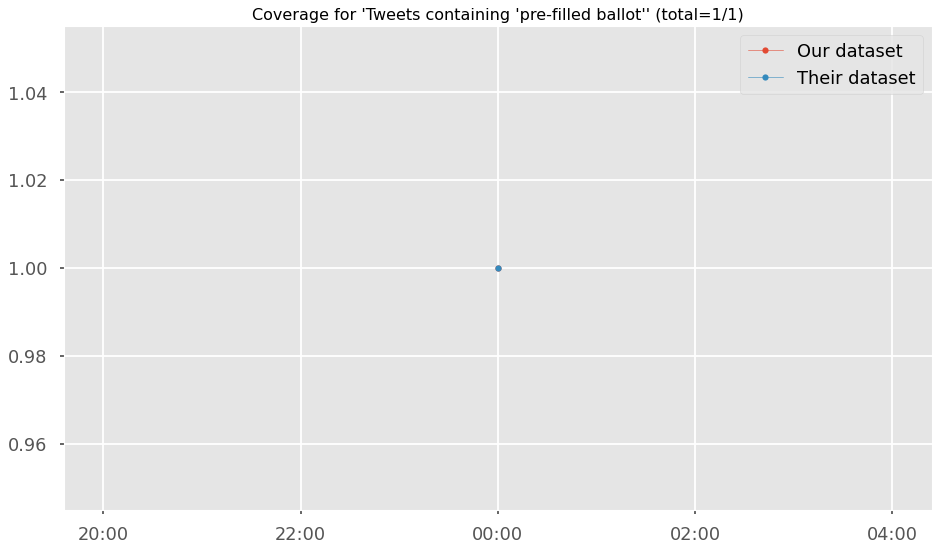

In [31]:
overlapping_terms = ["voter fraud", "ballot fraud", "ballot harvesting", "harvest ballot", "pre-filled ballot"]

for term in overlapping_terms:
    plot_hourly_coverage(tweet_df[tweet_df[term] == 1], filter_by_term(ferrata_tweet_df, term), "Tweets containing '{}'".format(term))


# Comparing Coverage for our Crawled Terms

In [96]:
crawled_term_coverage_comparison = []


for term in crawled_terms:
    if term in tweet_df.columns:
        our_tweets = tweet_df[tweet_df[term] == 1]
        ferrata_tweets = filter_by_term(ferrata_tweet_df, term)

        tweet_ids = set(our_tweets.index.values).union(set(ferrata_tweets["tweet_id"].values))

        crawled_term_coverage_comparison.append({
            "term": term,
            "combined_tweet_count": len(tweet_ids),
            "our_tweet_count": our_tweets.shape[0],
            "ferrata_tweet_count": ferrata_tweets.shape[0],
        })

In [98]:
crawled_term_coverage_comparison_df = pd.DataFrame(crawled_term_coverage_comparison).sort_values('combined_tweet_count', ascending=False).set_index("term")
crawled_term_coverage_comparison_df

,combined_tweet_count,our_tweet_count,ferrata_tweet_count
term,,,
voter fraud,58699,45325,20018
#stopthesteal,21362,18654,4232
election fraud,16462,14262,3327
#voterfraud,11370,8844,3998
#electionfraud,4206,3541,1013
ballot harvesting,2318,1801,807
election interference,2135,1885,397
ballot fraud,1971,1553,653
#electioninterference,802,671,175


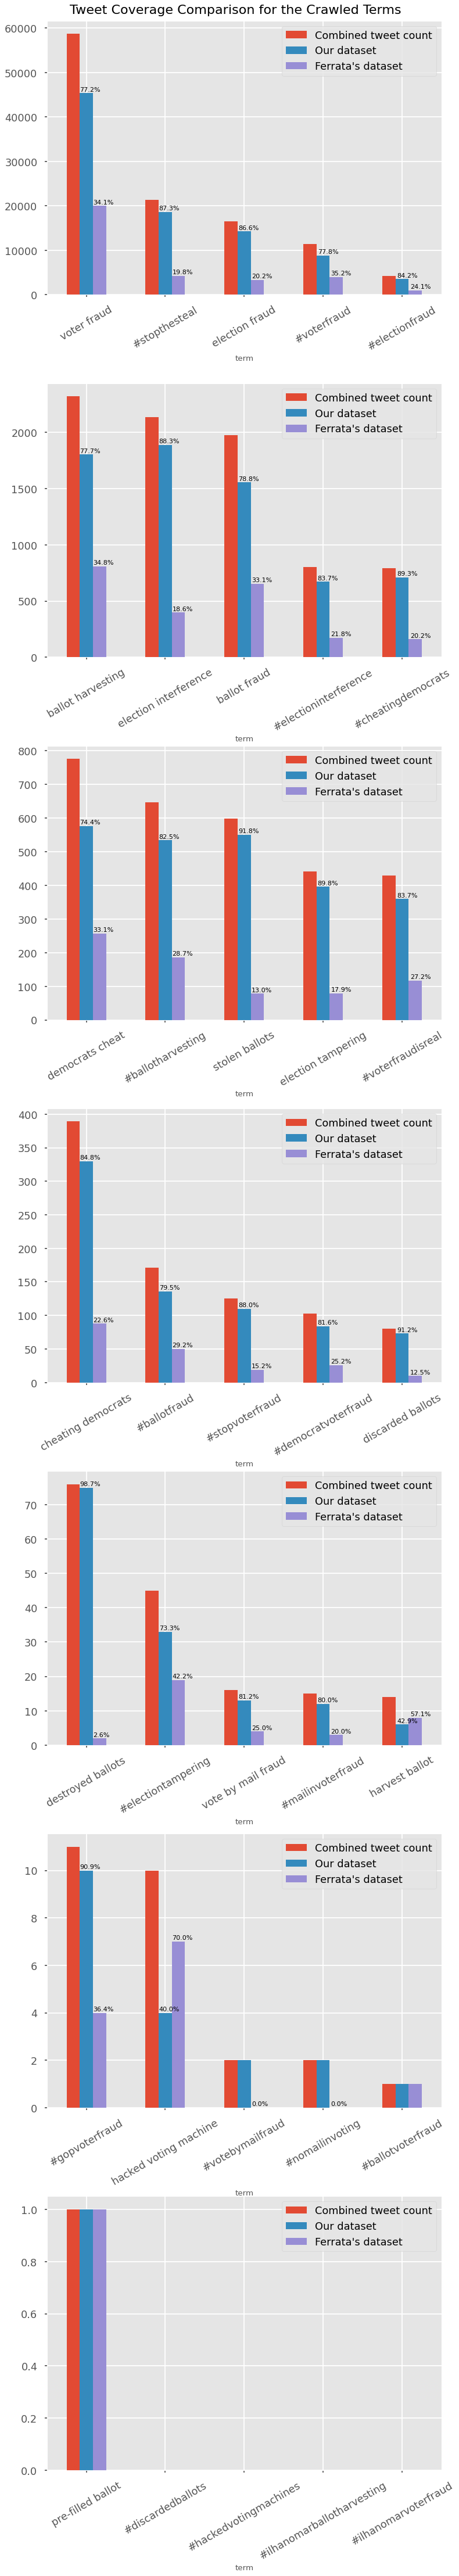

In [176]:
per_plot = 5
n_terms = crawled_term_coverage_comparison_df.shape[0]
n_plots = n_terms // per_plot
fig, axs = plt.subplots(n_plots, figsize=(12, n_plots * 8), dpi=80)
i = 0
fig.tight_layout(pad=10)
while i < n_terms:
    plot_df = crawled_term_coverage_comparison_df[i:i+per_plot]
    ax = axs[i // per_plot]
    plot_df.plot.bar(ax=ax, rot=30)

    for j, p in enumerate(ax.patches):
        row_index = j % plot_df.shape[0]
        feature_index = j // plot_df.shape[0]
        row = plot_df.iloc[row_index]
        total = row["combined_tweet_count"]
        patch_value = row.values[feature_index]

        if (patch_value != total):
            ax.annotate(
                "{:,.1f}%".format((patch_value / total) * 100), 
                (p.get_x() * 1.005, p.get_height() * 1.001),
                textcoords='offset points', xytext=(0, 3),
            )

    ax.legend(['Combined tweet count', 'Our dataset', 'Ferrata\'s dataset'])
    i += per_plot

plt.suptitle("Tweet Coverage Comparison for the Crawled Terms", fontsize=20)
plt.show()

# Reverse Coverage Test


In [84]:
term = "ballot"
our_ballot_tweet_ids = set()

for tweet_id, tweet_text in tweet_df[["text"]].itertuples():
    if term in tweet_text.lower():
        our_ballot_tweet_ids.add(tweet_id)

len(our_ballot_tweet_ids)

21391

In [85]:
diff = len(our_ballot_tweet_ids - ferrata_ballot_tweet_ids)

print("They are missing {:.2f}% of our ballot tweets".format((diff / len(our_ballot_tweet_ids)) * 100))

They are missing 87.60% of our ballot tweets
